# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow==2.20.0 scikit-learn==1.6.1 opencv-python==4.12.0.88 seaborn==0.13.2 matplotlib==3.10.0 numpy==2.4.1 pandas==2.2.2 -q

ERROR: Cannot install numpy==2.4.1, opencv-python==4.12.0.88, scikit-learn==1.6.1 and tensorflow==2.20.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.20.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [3]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                 # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importing matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                                       # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                            # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(42)

# **Data Overview**


 ## Loading the data

In [5]:
# Load the image file of the dataset
images = np.load('images_proj.npy')
images_original = images.copy()
labels = pd.read_csv('Labels_proj.csv')


In [6]:

# Images without helments are already stored in BGR format but images without them are normal images and therfor need to be converted.
images_with_helmet = images[labels['Label'] == 0]
images_without_helmet = images[labels['Label'] == 1]
# Try removing color correction
def correct_color(images):
  for i in range(len(images)):
      images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
correct_color(images)

# **Exploratory Data Analysis**

### Plot random images from each of the classes and print their corresponding labels.

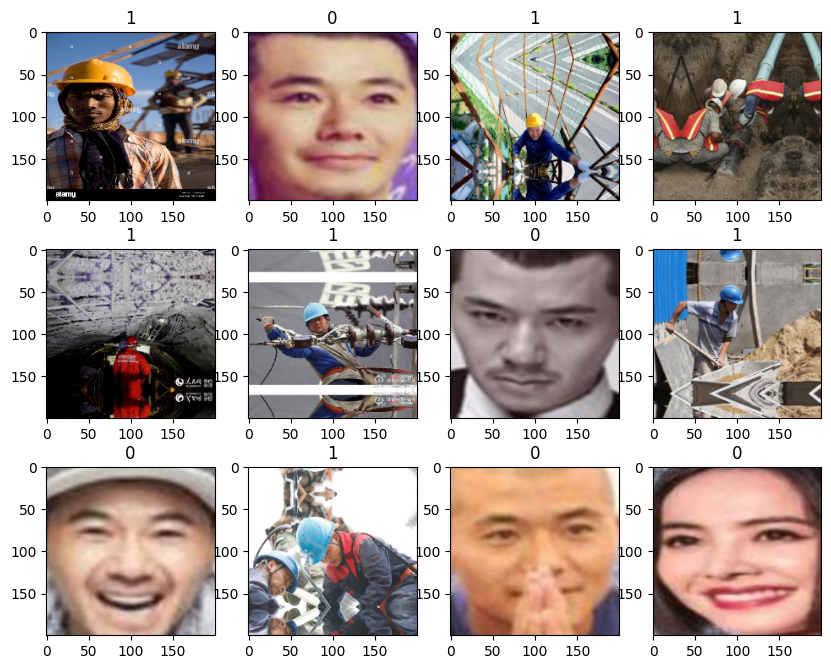

In [7]:
def plot_images(images,labels):
  num_classes=2                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtain the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index])                                         # Plotting the image
          ax.set_title(keys[random_index])
plot_images(images, labels)


## Checking for class imbalance


In [8]:
labels.shape
np.shape(labels)

(631, 1)

In [9]:
labels.info()
df_helmet = labels[labels['Label']==0]
df_no_helmet = labels[labels['Label']==1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   631 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [10]:
print(df_helmet.size)
print(df_no_helmet.size)

320
311


### Observations
 There are a similar number of images with and without helmets, but the images without helmets are more zoomed in than the images with helmets which might affect the performance of the final model.

# **Data Preprocessing**

## Converting images to grayscale

In [11]:
def to_greyscale(images):
  grey_images = []
  for i in range(len(images)):
    grey_images.append(cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY))
  return grey_images
greyscale = to_greyscale(images)

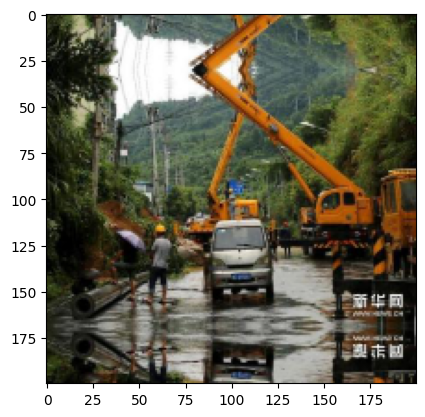

In [12]:
plt.imshow(images[0]);

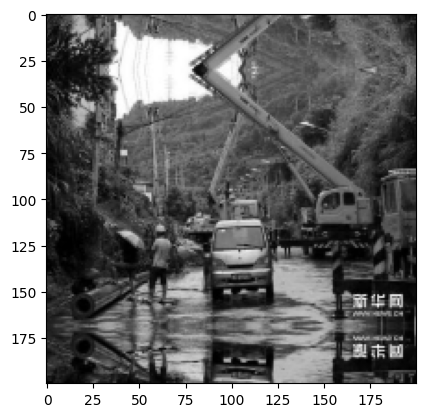

In [13]:

plt.imshow(greyscale[0], cmap='grey');

### Splitting the dataset



In [14]:
x_train, x_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

### Data Normalization

In [15]:
# Normalizing the image pixels
X_train = x_train.astype('float32')/255.0
X_val = x_val.astype('float32')/255.0
X_test = x_test.astype('float32')/255.0

# **Model Building**

## Model Evaluation Criterion

## Utility Functions

In [18]:
!pip install tensorflow==2.20.0

## Model 1: Simple Convolutional Neural Network (CNN)

In [19]:
model_1 = Sequential()
shape = (200,200,3)
model_1.add(Flatten(input_shape=(shape[0], shape[1],3)))
model_1.add(Dense(256, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

model_1.add(Dense(2, activation='softmax'))

In [20]:
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 120000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    30,720,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,763,554 (117.35 MB)

 Trainable params: 30,763,554 (117.35 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_datagen = ImageDataGenerator()

In [22]:

history_1 = model_1.fit(train_datagen.flow(X_train,y_train,batch_size=128),validation_data = (X_val,y_val),epochs=20, verbose=2)

Epoch 1/20
4/4 - 20s - 5s/step - accuracy: 0.4643 - loss: 40.1097 - val_accuracy: 0.5556 - val_loss: 2.2977
Epoch 2/20
4/4 - 3s - 834ms/step - accuracy: 0.6210 - loss: 5.6016 - val_accuracy: 0.6667 - val_loss: 3.1495
Epoch 3/20
4/4 - 1s - 318ms/step - accuracy: 0.6746 - loss: 4.2432 - val_accuracy: 0.6190 - val_loss: 7.7617
Epoch 4/20
4/4 - 1s - 285ms/step - accuracy: 0.7341 - loss: 4.4717 - val_accuracy: 0.6984 - val_loss: 6.2806
Epoch 5/20
4/4 - 1s - 251ms/step - accuracy: 0.7619 - loss: 4.1972 - val_accuracy: 0.8413 - val_loss: 2.2242
Epoch 6/20
4/4 - 1s - 339ms/step - accuracy: 0.8056 - loss: 2.7280 - val_accuracy: 0.7460 - val_loss: 2.8772
Epoch 7/20
4/4 - 2s - 409ms/step - accuracy: 0.8631 - loss: 1.9808 - val_accuracy: 0.8254 - val_loss: 1.7789
Epoch 8/20
4/4 - 1s - 217ms/step - accuracy: 0.9067 - loss: 1.2073 - val_accuracy: 0.8730 - val_loss: 1.1260
Epoch 9/20
4/4 - 1s - 229ms/step - accuracy: 0.9226 - loss: 0.9997 - val_accuracy: 0.8730 - val_loss: 0.9060
Epoch 10/20
4/4 - 1s

### Visualizing the predictions

In [23]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

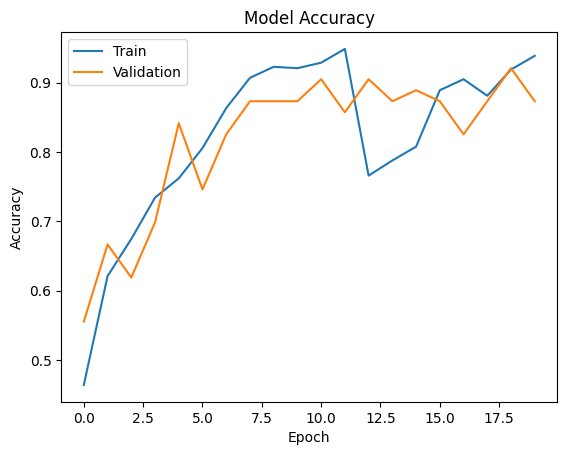

In [24]:
plot_history(history_1)

### Observations
The best model accuracy was at 10 epochs

## Model 2: (VGG-16 (Base))

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
# Load VGG16 base (no top classifier)
vgg_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(200, 200, 3)   # adjust if needed
)


# Freeze base layers
for layer in vgg_base.layers:
    layer.trainable = False

# Custom classification head
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # binary classification

# Final model
model_2 = Model(inputs=vgg_base.input, outputs=output)
# TODO fix error: NameError: name 'GlobalAveragePooling2D' is not defined

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Visualizing the prediction:

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5524 - loss: 0.7011 - val_accuracy: 0.9841 - val_loss: 0.5492
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7861 - loss: 0.5452 - val_accuracy: 1.0000 - val_loss: 0.4548
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.8885 - loss: 0.4559 - val_accuracy: 1.0000 - val_loss: 0.3784
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9315 - loss: 0.3850 - val_accuracy: 1.0000 - val_loss: 0.3171
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9709 - loss: 0.3145 - val_accuracy: 1.0000 - val_loss: 0.2673
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9874 - loss: 0.2704 - val_accuracy: 1.0000 - val_loss: 0.2260
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9906 - loss: 0.2466 - val_accuracy: 1.0000 - val_loss: 0.1906
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.9903 - loss: 0.1941 - val_accuracy: 1.00

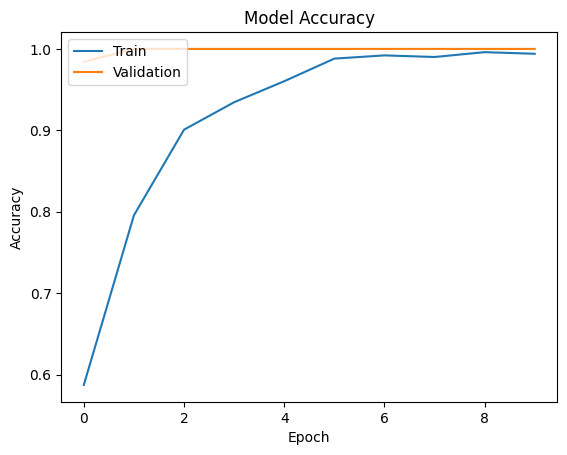

In [26]:
model_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_2.summary()
history_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
plot_history(model_2.history)

## Model 3: (VGG-16 (Base + FFNN))

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
# Load VGG16 base model
vgg_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(200, 200, 3)
)

# Freeze convolutional base
for layer in vgg_base.layers:
    layer.trainable = False

# FFNN classifier head
x = vgg_base.output
x = Flatten()(x)                     # key difference vs GAP
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

# Build model
model_3 = Model(inputs=vgg_base.input, outputs=output)

# Compile
model_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_3.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 24,220,737 (92.39 MB)

 Trainable params: 9,504,769 (36.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

#### Visualizing the predictions

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.8799 - loss: 0.3033 - val_accuracy: 0.9048 - val_loss: 0.2191
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0993
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0575
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0341
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0220
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1

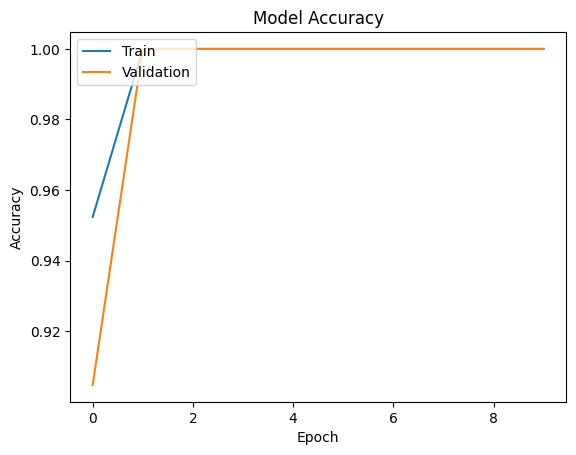

In [28]:
history_3 = model_3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(history_3)

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 200, 200,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 200, 200)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 200, 200)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 200, 200)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 200, 200,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 200,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ add[0][0]         │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][

 Total params: 24,220,737 (92.39 MB)

 Trainable params: 9,504,769 (36.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 561ms/step - accuracy: 0.7856 - loss: 0.4758 - val_accuracy: 0.4921 - val_loss: 1.3772
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9420 - loss: 0.1540 - val_accuracy: 0.4921 - val_loss: 1.8088
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9566 - loss: 0.1113 - val_accuracy: 0.4921 - val_loss: 1.9176
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9540 - loss: 0.1199 - val_accuracy: 0.4921 - val_loss: 1.8251
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9653 - loss: 0.0974 - val_accuracy: 0.4921 - val_loss: 1.8263
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9675 - loss: 0.0903 - val_accuracy: 0.4921 - val_loss: 1.7354
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9762 - loss: 0.0760 - val_accuracy: 0.4921 - val_loss: 1.3905
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9743 - loss: 0.0660 - val_accuracy: 0

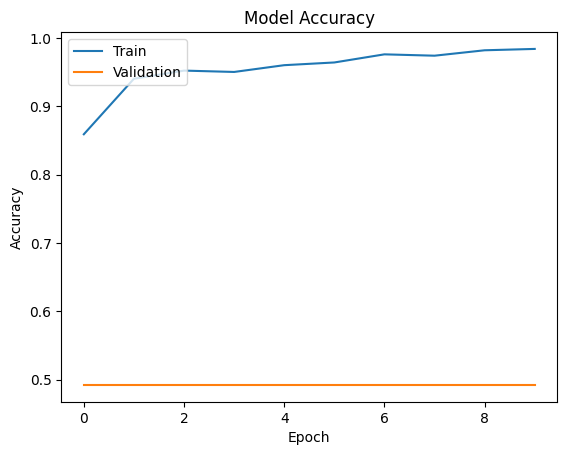

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam

# -------------------------------
# Data Augmentation Layer
# -------------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# -------------------------------
# Input
# -------------------------------
inputs = Input(shape=(200, 200, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)

# -------------------------------
# VGG16 Base
# -------------------------------
vgg_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

for layer in vgg_base.layers:
    layer.trainable = False

# -------------------------------
# FFNN Head
# -------------------------------
x = vgg_base.output
x = Flatten()(x)

x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation="sigmoid")(x)

# -------------------------------
# Model
# -------------------------------
model_4 = Model(inputs=inputs, outputs=outputs)

model_4.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_4.summary()
history_4 = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(history_4)

#### Visualizing the predictions

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9817 - loss: 0.0637 - val_accuracy: 0.9841 - val_loss: 0.3536
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9841 - loss: 0.0462 - val_accuracy: 0.9206 - val_loss: 0.2790
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9852 - loss: 0.0424 - val_accuracy: 0.9048 - val_loss: 0.2672
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9818 - loss: 0.0448 - val_accuracy: 1.0000 - val_loss: 0.2476
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9866 - loss: 0.0412 - val_accuracy: 0.4921 - val_loss: 0.8678
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9894 - loss: 0.0443 - val_accuracy: 0.4921 - val_loss: 0.6111
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9853 - loss: 0.0417 - val_accuracy: 0.7143 - val_loss: 0.3976
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9872 - loss: 0.0371 - val_accuracy: 0.

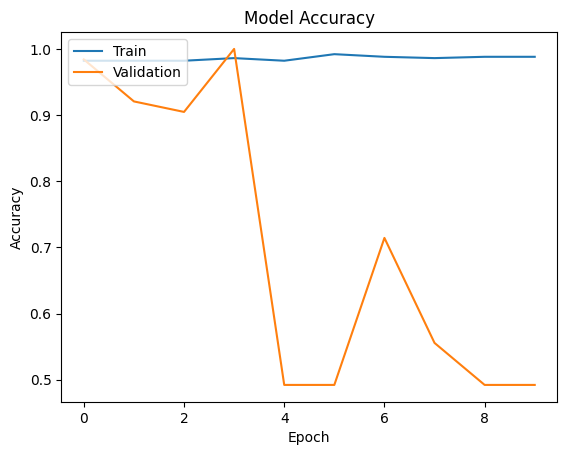

In [30]:
history_4 = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(history_4)

### Observation
- The augmented data helped for the first 3 epochs until the total accuracy dropped significantly.

# **Model Performance Comparison and Final Model Selection**

In [31]:
y_train = np.asarray(y_train).reshape(-1)
print(X_test.shape, y_test.shape)

X_test = X_test.reshape(-1, 200, 200, 3)
y_test = np.asarray(y_test).reshape(-1)
y_val = np.asarray(y_val).reshape(-1)

print(X_test.shape, y_test.shape)

(64, 200, 200, 3) (64, 1)
(64, 200, 200, 3) (64,)


In [37]:
from sklearn.metrics import accuracy_score
models = {
    "Model 1": model_1,
    "Model 2": model_2,
    "Model 3": model_3,
    "Model 4": model_4
}

# Store accuracy results
results = []

for name, mdl in models.items():
    # predict returns probabilities for sigmoid/softmax
    y_pred_prob = mdl.predict(X_test)

    # Convert to class labels
    success_threshold = 0.95
    if y_pred_prob.shape[1] == 1:  # binary classification
        y_pred = (y_pred_prob > success_threshold).astype(int).reshape(-1)
    else:  # multi-class classification
        y_pred = y_pred_prob.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred)
    results.append([name, acc])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


## Test Performance

In [38]:
df = pd.DataFrame(
    results,
    columns=["Model Name", "accuracy"]
)
df

,Model Name,accuracy
0,Model 1,0.953125
1,Model 2,0.578125
2,Model 3,0.984375
3,Model 4,1.000000


### Observations
- The success_threshold used has a large impact on the final model accuracy scores.
- I initially used a success_threshold of 50% and then changed it to 95% to prevent overfitting.
- Using too low of a value for success_threshold resulted in significant model overfitting.
- I believe that a value of between 95% and 50% is likely to result in the best results.




# **Actionable Insights & Recommendations**

- Based on the model visualization for model 2 and model 3 it looks like model 3 is heavily overfit, so trying a version of model 2 with a success_threshold between 95% and 50% might make sense.


<font size=5 color='blue'>Power Ahead!</font>
___